In [1]:
%load_ext autoreload
%autoreload 2
%aimport anndata
%aimport os
%aimport torch
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from typing import Dict, Union, List, Tuple
from torch.utils.data import Dataset
# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')
import copy
import scvi

# from scvi.dataset.cortex import CortexDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer, load_posterior
from scvi import set_seed
from scvi.dataset import setup_anndata

#STUFF THAT I MESSED AROUND WITH
# from BioDataset import BioDataset
# from constants import X_KEY, BATCH_KEY, LOCAL_L_MEAN_KEY, LOCAL_L_VAR_KEY, LABELS_KEY

# Sets torch and numpy random seeds, run after all scvi imports
set_seed(0)


In [2]:
save_path = "data/"
gene_dataset = CortexDataset(save_path=save_path, total_genes=None)
gene_dataset.subsample_genes(1000, mode="variance")
gene_dataset.make_gene_names_lower()


NameError: name 'CortexDataset' is not defined

In [3]:
adata = gene_dataset.to_anndata()

adata.layers['rawX'] = adata.X /10
adata.X = adata.X/10

setup_anndata(adata,batch_key=None, labels_key = 'precise_labels',X_layers_key = 'rawX' )



[2020-06-29 20:37:32,210] WARNING - scvi.dataset._anndata | adata.layers[rawX] does not contain unnormalized count data. Are you sure this is what you want?
[2020-06-29 20:37:32,210] INFO - scvi.dataset._anndata | Using data from adata.layers["rawX"]
[2020-06-29 20:37:32,211] INFO - scvi.dataset._anndata | No batch_key inputted, assuming all cells are same batch
[2020-06-29 20:37:32,216] INFO - scvi.dataset._anndata | Using labels from adata.obs["precise_labels"]
[2020-06-29 20:37:32,218] INFO - scvi.dataset._anndata | Computing library size prior per batch
[2020-06-29 20:37:32,227] INFO - scvi.dataset._anndata | Successfully registered anndata object containing 3005 cells, 1000 genes, and 1 batches 
Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']


In [4]:
adata.uns['scvi_data_registry']

{'X': ('layers', 'rawX'),
 'batch_indices': ('_obs', '_scvi_batch'),
 'local_l_mean': ('_obs', '_scvi_local_l_mean'),
 'local_l_var': ('_obs', '_scvi_local_l_var'),
 'labels': ('_obs', '_scvi_labels')}

In [5]:
adata.obs

,batch_indices,cell_types,precise_labels,_scvi_batch,_scvi_labels,_scvi_local_l_mean,_scvi_local_l_var
0,0,interneurons,1,0,0,6.376017,0.445956
1,0,interneurons,1,0,0,6.376017,0.445956
2,0,interneurons,1,0,0,6.376017,0.445956
3,0,interneurons,1,0,0,6.376017,0.445956
4,0,interneurons,1,0,0,6.376017,0.445956
...,...,...,...,...,...,...,...
3000,0,endothelial-mural,9,0,8,6.376017,0.445956
3001,0,endothelial-mural,9,0,8,6.376017,0.445956
3002,0,endothelial-mural,9,0,8,6.376017,0.445956
3003,0,endothelial-mural,9,0,8,6.376017,0.445956


In [6]:
n_epochs = 2
lr = 1e-3
use_cuda = True

#nbatch, ngenes, nproteins
vae = VAE(adata.shape[1], n_batch = adata.uns['scvi_summary_stats']['n_batch'])
trainer = UnsupervisedTrainer(
    vae,
    adata,
    train_size=0.90,
    n_epochs_kl_warmup = 2,
    use_cuda=use_cuda,
    frequency=5,
)
trainer.train(n_epochs = n_epochs)

[2020-06-29 20:37:32,366] WARNING - scvi.dataset._biodataset | Make sure the registered X field in anndata contains unnormalized count data.
[2020-06-29 20:37:32,398] WARNING - scvi.dataset._biodataset | Make sure the registered X field in anndata contains unnormalized count data.
[2020-06-29 20:37:32,430] WARNING - scvi.dataset._biodataset | Make sure the registered X field in anndata contains unnormalized count data.
[2020-06-29 20:37:32,670] INFO - scvi.inference.inference | KL warmup for 2 epochs



[2020-06-29 20:37:34,548] INFO - scvi.inference.inference | Training is still in warming up phase. If your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.


In [7]:
full = trainer.create_posterior(trainer.model, adata, indices=np.arange(len(gene_dataset)))

# make sure we delete this
full = full.update_batch_size(batch_size = 32)


[2020-06-29 20:37:34,613] WARNING - scvi.dataset._biodataset | Make sure the registered X field in anndata contains unnormalized count data.


In [8]:
for i in enumerate(full):
    pass

In [9]:
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()


In [ ]:
adata

In [10]:
full.sampler_kwargs

{'indices': array([   0,    1,    2, ..., 3002, 3003, 3004]),
 'batch_size': 128,
 'shuffle': False}

In [11]:
imputed_values = full.sequential().imputation()
normalized_values = full.sequential().get_sample_scale()


In [12]:
cell_types = gene_dataset.cell_types
print(gene_dataset.cell_types)
# oligodendrocytes (#4) VS pyramidal CA1 (#5)
couple_celltypes = (4, 5)  # the couple types on which to study DE

print("\nDifferential Expression A/B for cell types\nA: %s\nB: %s\n" %
      tuple((cell_types[couple_celltypes[i]] for i in [0, 1])))

cell_idx1 = gene_dataset.labels.ravel() == couple_celltypes[0]
cell_idx2 = gene_dataset.labels.ravel() == couple_celltypes[1]

['astrocytes_ependymal' 'endothelial-mural' 'interneurons' 'microglia'
 'oligodendrocytes' 'pyramidal CA1' 'pyramidal SS']

Differential Expression A/B for cell types
A: oligodendrocytes
B: pyramidal CA1



In [ ]:
n_samples = 100
M_permutation = 100000
de_res = full.differential_expression_score(
    cell_idx1,
    cell_idx2,
    n_samples=n_samples,
    M_permutation=M_permutation,
)


In [ ]:
de_res = full.differential_expression_score(
    cell_idx1,
    cell_idx2,
    n_samples=n_samples,
    M_permutation=M_permutation,
)


In [31]:
de_res

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2
gm9846,1.0,0.0,18.420681,0.001378,0.000502,0.619513,0.225027,0.762195,0.742279,0.801017,0.257151
slc12a2,1.0,0.0,18.420681,0.001564,0.000380,0.798171,0.075612,0.981707,0.361022,1.391874,0.080037
xist,1.0,0.0,18.420681,0.001784,0.000700,0.791951,0.680192,0.500000,0.425985,1.392538,0.733878
slc48a1,1.0,0.0,18.420681,0.001400,0.000363,0.772805,0.179127,0.978049,0.694356,1.393235,0.187054
1810037i17rik,1.0,0.0,18.420681,0.001265,0.000340,0.657927,0.243770,0.970732,0.731629,1.125159,0.250510
...,...,...,...,...,...,...,...,...,...,...,...
rab3c,0.0,1.0,-18.420681,0.000674,0.001403,0.043293,0.701384,0.134146,0.959531,0.064294,0.762974
uchl1,0.0,1.0,-18.420681,0.000679,0.001244,0.074024,1.218105,0.293902,0.990415,0.111965,1.227371
tcf4,0.0,1.0,-18.420681,0.001076,0.002313,0.460245,2.303407,0.896341,1.000000,0.781284,2.560721
3110035e14rik,0.0,1.0,-18.420681,0.000698,0.001621,0.109268,1.768478,0.219512,0.991480,0.163012,1.890319


In [32]:
genes_of_interest = ["thy1", "mbp"]
de_res.filter(items=genes_of_interest, axis=0)

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2
thy1,0.0,1.0,-18.420681,0.000573,0.001325,0.058902,1.356976,0.219512,0.996805,0.089729,1.444311
mbp,1.0,0.0,18.420681,0.004217,0.000814,5.531826,0.278701,0.998780,0.452609,8.840034,0.298456


In [33]:
per_cluster_de, cluster_id = full.one_vs_all_degenes(cell_labels=gene_dataset.labels.ravel(), min_cells=1)

markers = []
for x in per_cluster_de:
    markers.append(x[:10])
markers = pd.concat(markers)

genes = np.asarray(markers.index)
expression = [x.filter(items=genes, axis=0)['raw_normalized_mean1'] for x in per_cluster_de]
expression = pd.concat(expression, axis=1)
expression = np.log10(1 + expression)
expression.columns = gene_dataset.cell_types

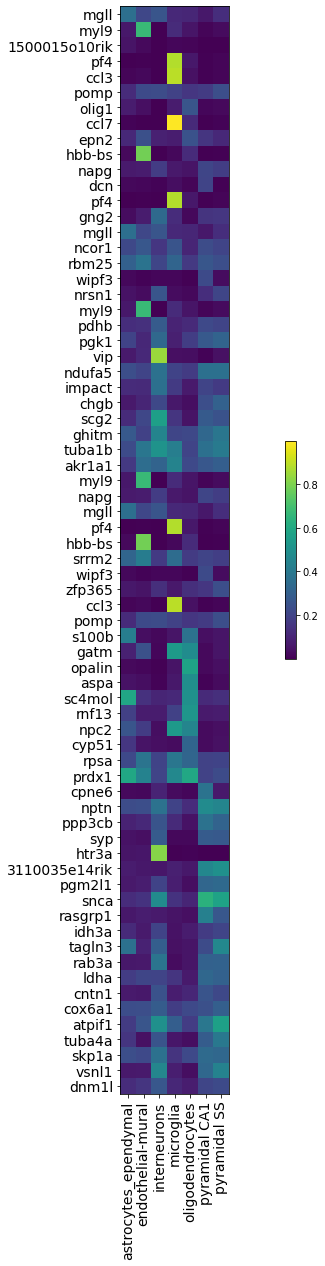

In [34]:
%matplotlib inline
plt.figure(figsize=(20, 20))
im = plt.imshow(expression, cmap='viridis', interpolation='none', aspect='equal')
ax = plt.gca()
ax.set_xticks(np.arange(0, 7, 1))
ax.set_xticklabels(gene_dataset.cell_types, rotation='vertical')
ax.set_yticklabels(genes)
ax.set_yticks(np.arange(0, 70, 1))
ax.tick_params(labelsize=14)
plt.colorbar(shrink=0.2)
